In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Define ML problems

# I. Wrangle Data

In [3]:
import pandas as pd

df = pd.read_csv(DATA_PATH+'burritos/burritos.csv',
                 parse_dates=['Date'], index_col='Date')

In [4]:
df.head()

,Location,Burrito,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,...,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-18,Donato's taco shop,California,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-24,Oscar's Mexican food,California,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-24,Oscar's Mexican food,Carnitas,NaN,NaN,NaN,NaN,NaN,NaN,4.85,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-24,Oscar's Mexican food,Carne asada,NaN,NaN,NaN,NaN,NaN,NaN,5.25,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-27,Pollos Maria,California,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 423 entries, 2016-01-18 to 2019-08-27
Data columns (total 65 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Location        423 non-null    object 
 1   Burrito         423 non-null    object 
 2   Neighborhood    92 non-null     object 
 3   Address         88 non-null     object 
 4   URL             87 non-null     object 
 5   Yelp            87 non-null     float64
 6   Google          87 non-null     float64
 7   Chips           26 non-null     object 
 8   Cost            416 non-null    float64
 9   Hunger          420 non-null    float64
 10  Mass (g)        22 non-null     float64
 11  Density (g/mL)  22 non-null     float64
 12  Length          284 non-null    float64
 13  Circum          282 non-null    float64
 14  Volume          282 non-null    float64
 15  Tortilla        423 non-null    float64
 16  Temp            403 non-null    float64
 17  Meat            

In [6]:
df.select_dtypes('object').nunique().sort_values()

Zucchini           1
Carrots            1
Unreliable         1
Chile relleno      1
Nopales            1
Lobster            1
Ham                1
Mushroom           1
Bacon              1
Sushi              1
Avocado            1
Egg                1
Tomato             2
Pineapple          2
Taquito            2
Onion              2
Cilantro           2
Salsa.1            2
Sauce              2
Cabbage            2
Bell peper         2
Lettuce            2
Beans              2
Rice               2
NonSD              2
Corn               2
Pico               2
Guac               2
Cheese             2
Beef               2
Sour cream         2
Pork               2
Chicken            2
Shrimp             2
Fish               2
Fries              2
Chips              4
Rec                6
Neighborhood      41
URL               86
Address           87
Reviewer         106
Location         108
Burrito          132
Notes            145
dtype: int64

In [7]:
df['Chicken'].value_counts()

x    20
X     1
Name: Chicken, dtype: int64

**Question:** What issues do we need to address in our `wrangle` function?

- "Weird values," eg. Yes/No/True/False/X/x/0/1
- High cardinality categorical features

In [8]:
def wrangle(df):
    df = df.copy()
    
    # We need to drop rows with no target
    df.dropna(subset=['overall'], inplace=True)
    
    # Create `'great'` column as target
    df['great'] = (df['overall'] >= 4).astype(int)
    
    # Drop `'overall'` col to avoid leakage
    df.drop(columns='overall', inplace=True)

    # Create OHE for burrito types
    burrito_cats = ['california', 'asada', 'carnitas', 'surf', 'pastor']
    for cat in burrito_cats:
        df[cat] = df['Burrito'].str.lower().str.strip().str.contains(cat).astype(int)
    df.drop(columns='Burrito', inplace=True)    
    
    # Fix binary columns
    categorical_cols = df.select_dtypes('object').nunique()
    binary_cols = [col for col in categorical_cols.index if categorical_cols[col] <= 2]
    for col in binary_cols:
        df[col] = df[col].apply(lambda x: 1 if isinstance(x, str) else 0)
    
    # Drop high-cardinality categorical variables
    threshold = 10
    high_card_cols = [col for col in categorical_cols.index 
                      if categorical_cols[col] > threshold]
    df.drop(high_card_cols, axis=1, inplace=True)
    
    # Dropping columns with high number of NaN values
    df.dropna(axis=1, thresh=300, inplace=True)

    return df

In [9]:
df = wrangle(df)

# II. Split Data

In [10]:
target = 'great'
y = df[target]
X = df.drop(target, axis=1)

In [11]:
training_set = df[df.index.year < 2017]
validation_set = df[df.index.year == 2017]
testing_set = df[df.index.year > 2017]

train_mask = X.index.year < 2017
X_train, y_train = X.loc[train_mask], y.loc[train_mask]

validation_mask = X.index.year == 2017
X_val, y_val = X.loc[validation_mask], y.loc[validation_mask]

test_mask = X.index.year > 2017
X_test, y_test = X.loc[test_mask], y.loc[test_mask]

In [12]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

298
85
38


# III. Establish Baseline

In [13]:
print('Baseline accuracy:', y_train.value_counts(normalize=True).max())

Baseline accuracy: 0.5906040268456376


# IV. Build the Model

- Transformers
    - `SimpleImputer`
    - `StandardScalar`
- Predictors
    - `LogisticRegression`
    - `RandomForestClassifier`

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve 
import matplotlib.pyplot as plt

In [21]:
rf = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier()
)

rf.fit(X_train, y_train);

In [23]:
lr = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression()
)

lr.fit(X_train, y_train);

In [24]:
rf.score(X_train, y_train)
rf.score(X_val, y_val)

0.8588235294117647

In [26]:
lr.score(X_train, y_train)
lr.score(X_val, y_val)

0.7764705882352941

In [28]:
print('Random Forest')
print(classification_report(y_val, rf.predict(X_val)))

Random Forest
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        47
           1       0.81      0.89      0.85        38

    accuracy                           0.86        85
   macro avg       0.86      0.86      0.86        85
weighted avg       0.86      0.86      0.86        85



In [31]:
print('Logistic Regression')
print(classification_report(y_val, lr.predict(X_val)))
plot_confusion_matrix(lr, y_val, lr.predict(X_val))

Logistic Regression
              precision    recall  f1-score   support

           0       0.91      0.66      0.77        47
           1       0.69      0.92      0.79        38

    accuracy                           0.78        85
   macro avg       0.80      0.79      0.78        85
weighted avg       0.81      0.78      0.77        85



ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1.
 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

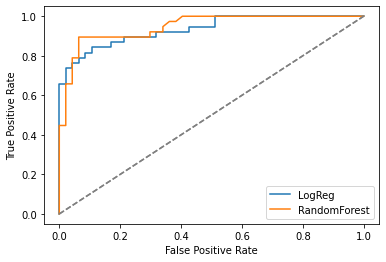

In [35]:
## ROC curve
model_lr = plot_roc_curve(lr, X_val, y_val, label='LogReg')
model_rf = plot_roc_curve(rf, X_val, y_val, ax=model_lr.ax_, label='RandomForest')
plt.plot([(0,0), (1,1)], color='gray', linestyle='--')
plt.legend();

In [ ]:
## Use to evaluate binary classification models

## Want True positive rate to be as high as possible right off the bat before it continues to the right